<a href="https://colab.research.google.com/github/LucasDatilioCarderelli/Maratona_BehindTheCode_IBM20/blob/main/Desafio%207/notebook7_TNT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DEF07-TNT

## Instalações

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import RFE
from sklearn.pipeline import make_pipeline, make_union
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import classification_report, accuracy_score, f1_score

In [ ]:
!pip install cloudant
from cloudant import Cloudant

u = '<username>'
p = '<pass>'
a = '<username>'

client = Cloudant(u,p, account=a, connect=True, auto_renev=True)

db = client['<your db>']

response = db.all_docs(include_docs=True)

docs=[]
for r in response["rows"]:
  docs.append(r["doc"])

df = pd.DataFrame(data=docs)
df.shape

(61962, 17)

In [ ]:
!wget --no-check-certificate --content-disposition https://gitlab.com/JoaoPedroPP/datasets/-/raw/master/ntn/to_be_scored.csv
df_toScore = pd.read_csv(r'to_be_scored.csv')
df_toScore.shape

--2020-09-11 14:14:16--  https://gitlab.com/JoaoPedroPP/datasets/-/raw/master/ntn/to_be_scored.csv
Resolving gitlab.com (gitlab.com)... 172.65.251.78, 2606:4700:90:0:f22e:fbec:5bed:a9b9
Connecting to gitlab.com (gitlab.com)|172.65.251.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/plain]
Saving to: ‘to_be_scored.csv.1’

to_be_scored.csv.1      [ <=>                ]  68.64K  --.-KB/s    in 0.02s   

2020-09-11 14:14:17 (3.02 MB/s) - ‘to_be_scored.csv.1’ saved [70291]



(984, 13)

In [ ]:
!pip install tpot
from tpot import TPOTClassifier

!pip install sweetviz
import sweetviz as sv

### Configurando o DataFrame

In [ ]:
df_toScore.head(3)

,Tempo,Estação,LAT,LONG,Movimentação,Original_473,Original_269,Zero,Maçã-Verde,Tangerina,Citrus,Açaí-Guaraná,Pêssego
0,2018-11-30,Moema,-23.5489,-46.6388,17533,22,65,22,14,3,26,43,18
1,2018-12-1,Moema,-23.5489,-46.6388,18412,11,56,16,14,43,20,37,15
2,2018-12-2,Moema,-23.5489,-46.6388,19600,86,51,8,11,41,20,35,12


In [ ]:
df.head(3)

,_id,_rev,Tempo,Estação,LAT,LONG,Movimentação,Original_473,Original_269,Zero,Maçã-Verde,Tangerina,Citrus,Açaí-Guaraná,Pêssego,TARGET,row
0,000ac62b7850525df9febd4a6701459f,1-7646c29b9af759fc976c9e9b82cd64e1,2019-3-11,Tamanduateí,-23.59290,-46.5897,50876,36,5,65,28,24,28,18,19,NORMAL,3311
1,000ac62b7850525df9febd4a67083d05,1-8a2f2b67f3b3349ed4d1a4cac2f1e7ef,2018-2-30,Trianon-Masp,-23.5634,-46.6544,43170,35,22,45,38,28,32,18,21,NORMAL,1500
2,000ac62b7850525df9febd4a670b30a4,1-ee40331887e30e56459d2fa13b3eb204,2018-4-12,Trianon-Masp,-23.5634,-46.6544,45646,39,18,21,43,10,10,24,9,NORMAL,1542


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61962 entries, 0 to 61961
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   _id           61962 non-null  object
 1   _rev          61962 non-null  object
 2   Tempo         61962 non-null  object
 3   Estação       61962 non-null  object
 4   LAT           61962 non-null  object
 5   LONG          61962 non-null  object
 6   Movimentação  61962 non-null  object
 7   Original_473  61962 non-null  object
 8   Original_269  61962 non-null  object
 9   Zero          61962 non-null  object
 10  Maçã-Verde    61962 non-null  object
 11  Tangerina     61962 non-null  object
 12  Citrus        61962 non-null  object
 13  Açaí-Guaraná  61962 non-null  object
 14  Pêssego       61962 non-null  object
 15  TARGET        61962 non-null  object
 16  row           61962 non-null  int64 
dtypes: int64(1), object(16)
memory usage: 8.0+ MB


In [ ]:
try:
  df.drop(["_id", "_rev"], axis=1, inplace=True)
  df.drop_duplicates(subset=["row"], inplace=True)
except: print("Already Droped")

In [ ]:
df = df.set_index("row").sort_index()
df

,Tempo,Estação,LAT,LONG,Movimentação,Original_473,Original_269,Zero,Maçã-Verde,Tangerina,Citrus,Açaí-Guaraná,Pêssego,TARGET
row,,,,,,,,,,,,,,
1,2018-1-1,Paraíso,-23.57677,-46.63933,70277,86,65,65,43,43,43,43,43,NORMAL
2,2018-1-2,Paraíso,-23.57677,-46.63933,73302,73,58,58,38,37,42,41,39,NORMAL
3,2018-1-3,Paraíso,-23.57677,-46.63933,71711,64,50,50,33,34,42,39,35,NORMAL
4,2018-1-4,Paraíso,-23.57677,-46.63933,71740,52,48,42,27,29,36,37,32,NORMAL
5,2018-1-5,Paraíso,-23.57677,-46.63933,71035,41,40,32,21,23,36,34,26,NORMAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17012,2019-12-26,Hospital São Paulo,-23.5984,-46.6455,25702,53,54,26,38,23,25,11,37,NORMAL
17013,2019-12-27,Hospital São Paulo,-23.5984,-46.6455,26236,43,52,17,33,18,21,5,35,REABASTECER
17014,2019-12-28,Hospital São Paulo,-23.5984,-46.6455,27174,34,50,9,28,15,16,43,32,NORMAL


## Analise Exploratoria

In [ ]:
colsInt = ["Movimentação", "Original_473", "Original_269", "Zero", 
           "Maçã-Verde", "Tangerina", "Citrus", "Açaí-Guaraná", "Pêssego"]
df[colsInt] = df[colsInt].astype(int)

### Coluna "Tempo"

In [ ]:
df[["LAT", "LONG"]] = df[["LAT", "LONG"]].astype(float)

df["ano"] = df["Tempo"].str[:4].astype(int)
df["mes"] = df["Tempo"].str[5:7].str.replace("-", "").astype(int)
df["dia"] = df["Tempo"].str[7:].str.replace("-", "").astype(int)

df.head()

,Tempo,Estação,LAT,LONG,Movimentação,Original_473,Original_269,Zero,Maçã-Verde,Tangerina,Citrus,Açaí-Guaraná,Pêssego,TARGET,quantidade,media,min,max,logMovQunt,ano,mes,dia
row,,,,,,,,,,,,,,,,,,,,,,
1,2018-1-1,Paraíso,-23.57677,-46.63933,70277,86,65,65,43,43,43,43,43,NORMAL,431,53,43,86,5.094092,2018,1,1
2,2018-1-2,Paraíso,-23.57677,-46.63933,73302,73,58,58,38,37,42,41,39,NORMAL,386,48,37,73,5.246506,2018,1,2
3,2018-1-3,Paraíso,-23.57677,-46.63933,71711,64,50,50,33,34,42,39,35,NORMAL,347,43,33,64,5.331075,2018,1,3
4,2018-1-4,Paraíso,-23.57677,-46.63933,71740,52,48,42,27,29,36,37,32,NORMAL,303,37,27,52,5.467071,2018,1,4
5,2018-1-5,Paraíso,-23.57677,-46.63933,71035,41,40,32,21,23,36,34,26,NORMAL,253,31,21,41,5.637539,2018,1,5


### Colunas Bebidas

In [ ]:
bebidas = ["Original_473", "Original_269", "Zero", "Maçã-Verde", 
           "Tangerina", "Citrus", "Açaí-Guaraná", "Pêssego"]

df["quantidade"] = df[bebidas].sum(axis=1)
df["media"] = df[bebidas].mean(axis=1).astype(int)
df["min"] = df[bebidas].min(axis=1).astype(int)
df["max"] = df[bebidas].max(axis=1).astype(int)

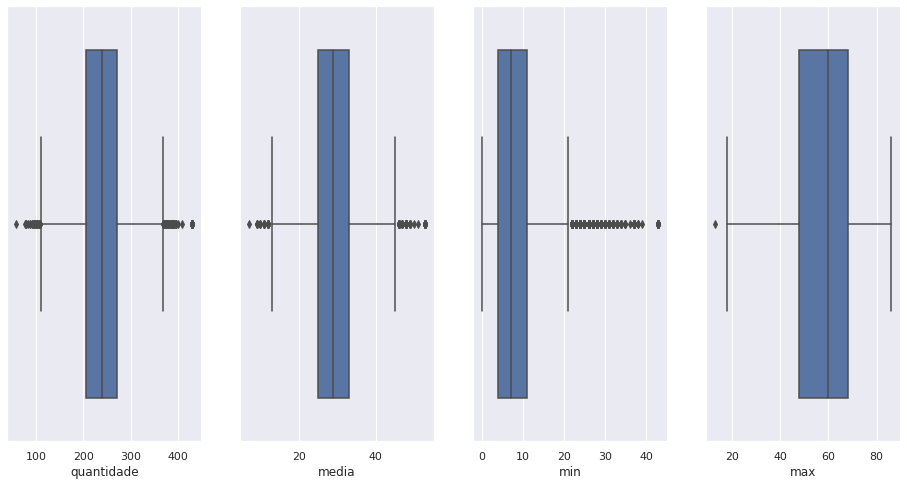

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 4, 1)
sns.boxplot(df["quantidade"])
plt.subplot(1, 4, 2)
sns.boxplot(df["media"])
plt.subplot(1, 4, 3)
sns.boxplot(df["min"])
plt.subplot(1, 4, 4)
sns.boxplot(df["max"]);

### Analise "Target"

In [ ]:
df.TARGET.value_counts()

NORMAL         11250
REABASTECER     5332
Name: TARGET, dtype: int64

In [ ]:
df[["TARGET", "quantidade", "media", "min", "max"]].groupby(by="TARGET").median()

,quantidade,media,min,max
TARGET,,,,
NORMAL,248,31,9,61
REABASTECER,221,27,5,58


In [ ]:
df[["Estação", "TARGET", "Movimentação", "quantidade"] + bebidas
   ].groupby(by=["Estação", "TARGET"]).min()

Movimentação  ...  Pêssego
Estação                TARGET                     ...         
Ana Rosa               NORMAL              63709  ...        1
                       REABASTECER         63698  ...        1
Barra Funda            NORMAL             146740  ...        1
                       REABASTECER        146756  ...        1
Brigadeiro             NORMAL              45932  ...        1
                       REABASTECER         45942  ...        1
Brooklin               NORMAL              26069  ...        2
                       REABASTECER         26063  ...        2
Brás                   NORMAL              70499  ...        2
                       REABASTECER         70505  ...        1
Butantã                NORMAL              64001  ...        1
                       REABASTECER         64025  ...        1
Campo Belo             NORMAL              23025  ...        1
                       REABASTECER         23033  ...        1
Consolação             NORMAL             111573  ...        1
                       REABASTECER        111589  ...        1
Eucaliptos             NORMAL              21584  ...        1
                       REABASTECER         21626  ...        1
Faria Lima             NORMAL              51013  ...        1
                       REABASTECER         51021  ...        1
Fradique Coutinho      NORMAL              33008  ...        2
                       REABASTECER         33028  ...        1
Higienópolis-Mackenzie NORMAL              89572  ...        2
                       REABASTECER         89596  ...        1
Hospital São Paulo     NORMAL              23896  ...        2
                       REABASTECER         23882  ...        1
Luz                    NORMAL             123889  ...        1
                       REABASTECER        123902  ...        1
Moema                  NORMAL              16950  ...        1
                       REABASTECER         16938  ...        1
Paraíso                NORMAL              70088  ...        1
                       REABASTECER         70077  ...        1
Pinheiros              NORMAL              76009  ...        1
                       REABASTECER         76051  ...        2
República              NORMAL             107074  ...        2
                       REABASTECER        107058  ...        1
São Joaquim            NORMAL              32592  ...        2
                       REABASTECER         32607  ...        1
São Judas              NORMAL              13592  ...        1
                       REABASTECER         13625  ...        1
Sé                     NORMAL             191316  ...        1
                       REABASTECER        191316  ...        1
Tamanduateí            NORMAL              49435  ...        2
                       REABASTECER         49456  ...        1
Tatuapé                NORMAL              67069  ...        1
                       REABASTECER         67061  ...        1
Trianon-Masp           NORMAL              41899  ...        1
                       REABASTECER         41898  ...        1
Vila Mariana           NORMAL              21064  ...        1
                       REABASTECER         21081  ...        1

[50 rows x 10 columns]

In [ ]:
df.query("quantidade > 240 & TARGET == 'REABASTECER'").shape

(1726, 18)

In [ ]:
df["Estação"].value_counts()

Trianon-Masp              713
Consolação                709
Brigadeiro                705
Campo Belo                705
São Joaquim               704
Paraíso                   704
Luz                       704
República                 703
Fradique Coutinho         703
Barra Funda               703
Faria Lima                702
Butantã                   701
Tatuapé                   701
Ana Rosa                  701
Pinheiros                 701
Brás                      700
Brooklin                  700
Tamanduateí               700
Eucaliptos                699
São Judas                 697
Vila Mariana              695
Higienópolis-Mackenzie    694
Sé                        693
Moema                     319
Hospital São Paulo        126
Name: Estação, dtype: int64

In [ ]:
df["logMovQunt"] = np.log(df["Movimentação"] / df["quantidade"])
df[["logMovQunt", "TARGET"]].groupby(by="TARGET").median()

,logMovQunt
TARGET,
NORMAL,5.471985
REABASTECER,5.585982


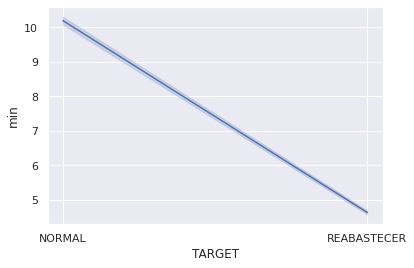

In [ ]:
sns.lineplot(x=df["TARGET"], y=df["min"])

### SweetViz

In [ ]:
my_report = sv.analyze(df)
my_report.show_html()

:FEATURES DONE:                    |█████████████████████| [100%]   00:10  -> (00:00 left)
:PAIRWISE DONE:                    |█████████████████████| [100%]   00:00  -> (00:00 left)


Creating Associations graph... DONE!
Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: no browser will pop up, the report is saved in your notebook/colab files.


### Validação

In [ ]:
df_toScore

,Tempo,Estação,LAT,LONG,Movimentação,Original_473,Original_269,Zero,Maçã-Verde,Tangerina,Citrus,Açaí-Guaraná,Pêssego
0,2018-11-30,Moema,-23.5489,-46.6388,17533,22,65,22,14,3,26,43,18
1,2018-12-1,Moema,-23.5489,-46.6388,18412,11,56,16,14,43,20,37,15
2,2018-12-2,Moema,-23.5489,-46.6388,19600,86,51,8,11,41,20,35,12
3,2018-12-3,Moema,-23.5489,-46.6388,20303,76,47,65,11,37,14,32,10
4,2018-12-4,Moema,-23.5489,-46.6388,17085,68,42,60,6,35,13,26,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
979,2019-8-19,Hospital São Paulo,-23.5984,-46.6455,26787,34,65,28,17,33,27,6,2
980,2019-8-20,Hospital São Paulo,-23.5984,-46.6455,26629,21,60,18,15,27,22,43,43
981,2019-8-21,Hospital São Paulo,-23.5984,-46.6455,27517,9,56,13,14,21,17,37,37
982,2019-8-22,Hospital São Paulo,-23.5984,-46.6455,26860,86,49,7,14,17,12,33,33


## Modelo

### Removendo dados

In [ ]:
df.head(3)

,Tempo,Estação,LAT,LONG,Movimentação,Original_473,Original_269,Zero,Maçã-Verde,Tangerina,Citrus,Açaí-Guaraná,Pêssego,TARGET,quantidade,media,min,max,logMovQunt,ano,mes,dia
row,,,,,,,,,,,,,,,,,,,,,,
1,2018-1-1,Paraíso,-23.57677,-46.63933,70277,86,65,65,43,43,43,43,43,NORMAL,431,53,43,86,5.094092,2018,1,1
2,2018-1-2,Paraíso,-23.57677,-46.63933,73302,73,58,58,38,37,42,41,39,NORMAL,386,48,37,73,5.246506,2018,1,2
3,2018-1-3,Paraíso,-23.57677,-46.63933,71711,64,50,50,33,34,42,39,35,NORMAL,347,43,33,64,5.331075,2018,1,3


In [ ]:
df.loc[(df["TARGET"] == "NORMAL") & ((df["min"] < 2) | (df["quantidade"] < 106))]

,Tempo,Estação,LAT,LONG,Movimentação,Original_473,Original_269,Zero,Maçã-Verde,Tangerina,Citrus,Açaí-Guaraná,Pêssego,TARGET,quantidade,media,min,max,logMovQunt,ano,mes,dia
row,,,,,,,,,,,,,,,,,,,,,,
29,2018-1-29,Paraíso,-23.57677,-46.63933,73188,73,49,1,19,7,18,28,20,NORMAL,215,26,1,73,5.830149,2018,1,29
52,2018-2-22,Paraíso,-23.57677,-46.63933,72187,11,27,35,42,1,43,12,25,NORMAL,196,24,1,43,5.908901,2018,2,22
88,2018-3-28,Paraíso,-23.57677,-46.63933,71757,4,65,48,23,21,11,31,1,NORMAL,204,25,1,65,5.862921,2018,3,28
181,2018-7-1,Paraíso,-23.57677,-46.63933,73974,40,1,49,37,43,19,19,37,NORMAL,245,30,1,49,5.710211,2018,7,1
350,2018-12-20,Paraíso,-23.57677,-46.63933,70921,8,33,1,21,39,31,27,4,NORMAL,164,20,1,39,6.069455,2018,12,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16706,2018-5-26,Moema,-23.54890,-46.63880,17168,57,65,65,20,14,22,1,18,NORMAL,262,32,1,65,4.182458,2018,5,26
16715,2018-6-5,Moema,-23.54890,-46.63880,17408,44,65,7,39,19,1,4,27,NORMAL,206,25,1,65,4.436809,2018,6,5
16846,2018-10-16,Moema,-23.54890,-46.63880,19035,40,17,0,23,40,39,43,13,NORMAL,215,26,0,43,4.483397,2018,10,16


In [ ]:
index_min2 = df.loc[(df["TARGET"] == "NORMAL") & ((df["min"] < 2) | (df["quantidade"] < 106))].index
index_max12 = df.loc[(df["TARGET"] == "REABASTECER") & ((df["min"] > 12) | (df["quantidade"] > 333))].index

In [ ]:
df_droped = df.drop(index_min2, axis=0)
df_droped = df.drop(index_max12, axis=0)

### Separando dados

In [ ]:
data = df[bebidas + ["TARGET"]]
y = df["TARGET"]
X = df[bebidas + ["min", "quantidade"]]
X

,Original_473,Original_269,Zero,Maçã-Verde,Tangerina,Citrus,Açaí-Guaraná,Pêssego,min,quantidade
row,,,,,,,,,,
1,86,65,65,43,43,43,43,43,43,431
2,73,58,58,38,37,42,41,39,37,386
3,64,50,50,33,34,42,39,35,33,347
4,52,48,42,27,29,36,37,32,27,303
5,41,40,32,21,23,36,34,26,21,253
...,...,...,...,...,...,...,...,...,...,...
17012,53,54,26,38,23,25,11,37,11,267
17013,43,52,17,33,18,21,5,35,5,224
17014,34,50,9,28,15,16,43,32,9,227


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.7, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((11607, 10), (4975, 10), (11607,), (4975,))

In [ ]:
smt = SMOTE(random_state=0)
X_smt, y_smt = smt.fit_resample(X_train, y_train)
X_smt.shape, y_smt.shape

((15832, 8), (15832,))

In [ ]:
sme = SMOTEENN(random_state=0)
X_res, y_res = sme.fit_resample(X_train, y_train)
X_res.shape, y_res.shape

((8809, 8), (8809,))

In [ ]:
rus = RandomUnderSampler(random_state=0)
X_rus, y_rus = rus.fit_resample(X_train, y_train)
X_rus.shape, y_rus.shape

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


((7382, 10), (7382,))

#### Serando df dropado

In [ ]:
X_droped = df_droped.drop("TARGET", 1)
X_droped = X_droped[bebidas + ["min", "max", "quantidade"]]
X_droped = X_droped.drop(["Maçã-Verde", "Açaí-Guaraná", "max", "quantidade", 
                          "Tangerina", "Citrus", "Pêssego"], 1)
y_droped = df_droped["TARGET"]

In [ ]:
y_droped.value_counts()

NORMAL         11250
REABASTECER     5312
Name: TARGET, dtype: int64

In [ ]:
X_droped

,Original_473,Original_269,Zero,min
row,,,,
1,86,65,65,43
2,73,58,58,37
3,64,50,50,33
4,52,48,42,27
5,41,40,32,21
...,...,...,...,...
17012,53,54,26,11
17013,43,52,17,5
17014,34,50,9,9


In [ ]:
X_train_droped, X_test_droped, y_train_droped, y_test_droped = train_test_split(
    X_droped, y_droped, train_size = .7, random_state = 0)
X_train_droped.shape, X_test_droped.shape, y_train_droped.shape, y_test_droped.shape

((11593, 4), (4969, 4), (11593,), (4969,))

In [ ]:
X_rus_droped, y_rus_droped = rus.fit_resample(X_train_droped, y_train_droped)
X_rus_droped.shape, y_rus_droped.shape

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


((7362, 4), (7362,))

### Feature Selection

In [ ]:
fs = DecisionTreeClassifier(max_depth=8, min_samples_leaf=19, min_samples_split=15)
fs.fit(X_rus, y_rus)
p_fs = fs.predict(X_test)
print(f1_score(y_test, p_fs, average="micro"))
print(classification_report(y_test, p_fs, digits=4))

0.7807035175879397
              precision    recall  f1-score   support

      NORMAL     0.9659    0.6974    0.8100      3334
 REABASTECER     0.6071    0.9500    0.7408      1641

    accuracy                         0.7807      4975
   macro avg     0.7865    0.8237    0.7754      4975
weighted avg     0.8476    0.7807    0.7871      4975



In [ ]:
for n in range(0, len(fs.feature_importances_)):
  print(f"{X.columns[n]:<15}{fs.feature_importances_[n]}")

Original_473   0.12616711382222473
Original_269   0.10465801469872324
Zero           0.11043106440737152
Maçã-Verde     0.012512489719065344
Tangerina      0.00381927826352334
Citrus         0.015135080324054315
Açaí-Guaraná   0.006891584893653783
Pêssego        0.011301546700154916
min            0.5980017493662503
quantidade     0.011082077804978514


In [ ]:
fs2 = DecisionTreeClassifier(max_depth=8, min_samples_leaf=19, min_samples_split=15)
fs2.fit(X_rus_droped, y_rus_droped)
p_fs2 = fs2.predict(X_test_droped)
print(f1_score(y_test_droped, p_fs2, average="micro"))
print(classification_report(y_test_droped, p_fs2, digits=4))

0.7862749044073254
              precision    recall  f1-score   support

      NORMAL     0.9926    0.6869    0.8120      3338
 REABASTECER     0.6070    0.9896    0.7524      1631

    accuracy                         0.7863      4969
   macro avg     0.7998    0.8383    0.7822      4969
weighted avg     0.8661    0.7863    0.7924      4969



In [ ]:
for n in range(0, len(fs2.feature_importances_)):
  print(f"{X_droped.columns[n]:<15}{fs2.feature_importances_[n]*100:>7.4f}%")

Original_473   13.8986%
Original_269   11.3843%
Zero           10.9632%
min            63.7539%


### PyCaret

In [ ]:
!pip install pycaret
from pycaret.classification import *

#### Pycaret1

In [ ]:
clf1 = setup(data, target = 'TARGET')

Setup Succesfully Completed!


,Description,Value
0,session_id,8719
1,Target Type,Binary
2,Label Encoded,"NORMAL: 0, REABASTECER: 1"
3,Original Data,"(16582, 18)"
4,Missing Values,False
5,Numeric Features,15
6,Categorical Features,2
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [ ]:
best_model = compare_models(sort="F1", n_select=3, exclude=["svm", "qda"])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Gradient Boosting Classifier,0.7707,0.8408,0.8759,0.5983,0.7107,0.5318,0.5587,3.0654
1,Extreme Gradient Boosting,0.7676,0.8420,0.8564,0.5970,0.7033,0.5223,0.5456,0.8181
2,Light Gradient Boosting Machine,0.7651,0.8404,0.8240,0.5984,0.6930,0.5106,0.5281,0.2241
3,CatBoost Classifier,0.7626,0.8449,0.7990,0.5984,0.6841,0.5003,0.5140,9.8802
4,Ada Boost Classifier,0.7478,0.8400,0.6669,0.5974,0.6297,0.4395,0.4416,0.8020
5,Naive Bayes,0.7060,0.7862,0.6967,0.5329,0.6038,0.3766,0.3853,0.0094
6,Decision Tree Classifier,0.7331,0.6909,0.5726,0.5877,0.5797,0.3843,0.3846,0.1138
7,Random Forest Classifier,0.7353,0.8369,0.5600,0.5940,0.5762,0.3841,0.3846,0.2128
8,Extra Trees Classifier,0.7361,0.8357,0.5188,0.6052,0.5584,0.3719,0.3742,1.0641
9,Logistic Regression,0.7166,0.7959,0.4298,0.5812,0.4927,0.3027,0.3100,0.2514


In [ ]:
gbc = create_model("gbc")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7519,0.8170,0.8770,0.5754,0.6949,0.5007,0.5323
1,0.7941,0.8587,0.8743,0.6301,0.7324,0.5722,0.5925
2,0.7752,0.8415,0.8820,0.6026,0.7160,0.5406,0.5676
3,0.7674,0.8355,0.8740,0.5938,0.7072,0.5257,0.5528
4,0.7562,0.8322,0.8445,0.5833,0.6900,0.5000,0.5233
5,0.7735,0.8520,0.8472,0.6054,0.7061,0.5300,0.5499
6,0.7752,0.8331,0.9088,0.5989,0.7220,0.5463,0.5799
7,0.7871,0.8589,0.8686,0.6207,0.7240,0.5584,0.5793
8,0.7448,0.8349,0.8606,0.5681,0.6844,0.4849,0.5145
9,0.7810,0.8439,0.9223,0.6046,0.7304,0.5591,0.5946


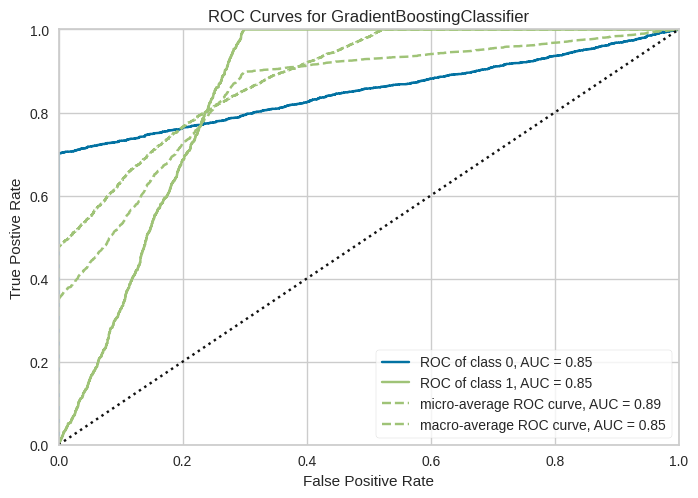

In [ ]:
plot_model(gbc)

In [ ]:
!pip install shap

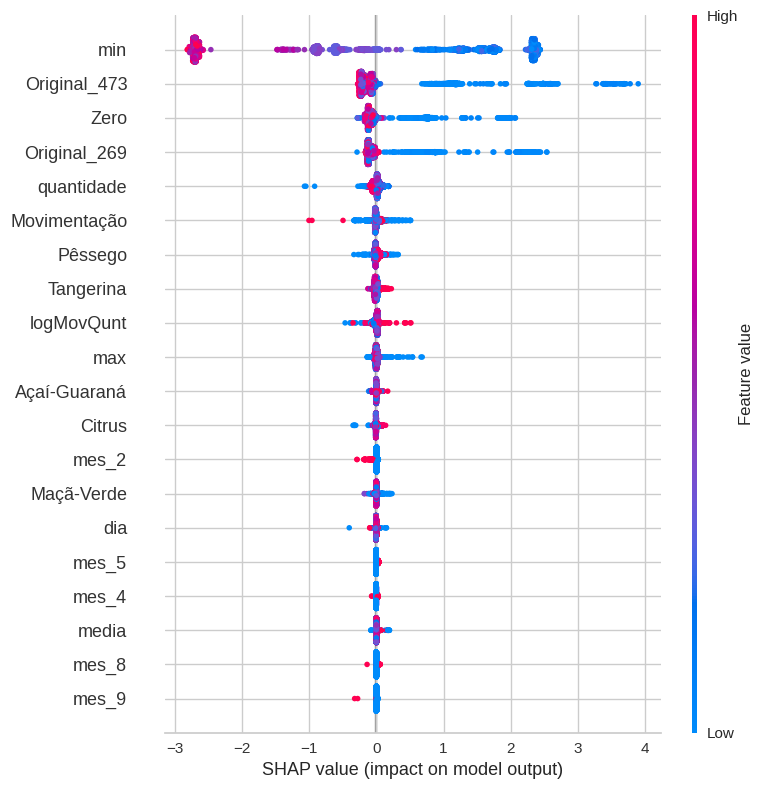

In [ ]:
interpret_model(gbc)

In [ ]:
calibrated_gbc = calibrate_model(gbc)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7468,0.8196,0.8663,0.5704,0.6879,0.4896,0.5200
1,0.7950,0.8623,0.8717,0.6318,0.7326,0.5731,0.5927
2,0.7786,0.8407,0.8954,0.6051,0.7222,0.5494,0.5786
3,0.7683,0.8339,0.8633,0.5963,0.7054,0.5248,0.5492
4,0.7597,0.8327,0.8472,0.5874,0.6937,0.5065,0.5295
5,0.7709,0.8536,0.8418,0.6027,0.7025,0.5243,0.5437
6,0.7769,0.8343,0.9062,0.6014,0.7230,0.5487,0.5811
7,0.7853,0.8618,0.8686,0.6183,0.7224,0.5554,0.5767
8,0.7466,0.8364,0.8579,0.5704,0.6852,0.4871,0.5156
9,0.7853,0.8399,0.9303,0.6088,0.7359,0.5680,0.6044


In [ ]:
final_gbc = finalize_model(gbc)

In [ ]:
unseen_predict = predict_model(final_gbc, data=df_toScore2)
unseen_predict

,Movimentação,Original_473,Original_269,Zero,Maçã-Verde,Tangerina,Citrus,Açaí-Guaraná,Pêssego,ano,mes,dia,quantidade,media,min,max,logMovQunt,Label,Score
0,17533,22,65,22,14,3,26,43,18,2018,11,30,213,26,3,65,4.410548,REABASTECER,0.5553
1,18412,11,56,16,14,43,20,37,15,2018,12,1,212,26,11,56,4.464172,REABASTECER,0.6685
2,19600,86,51,8,11,41,20,35,12,2018,12,2,264,33,8,86,4.307336,REABASTECER,0.5218
3,20303,76,47,65,11,37,14,32,10,2018,12,3,292,36,10,76,4.241770,NORMAL,0.0053
4,17085,68,42,60,6,35,13,26,5,2018,12,4,255,31,5,68,4.204693,NORMAL,0.4980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
979,26787,34,65,28,17,33,27,6,2,2019,8,19,212,26,2,65,4.839086,REABASTECER,0.6911
980,26629,21,60,18,15,27,22,43,43,2019,8,20,249,31,15,60,4.672303,NORMAL,0.0057
981,27517,9,56,13,14,21,17,37,37,2019,8,21,204,25,9,56,4.904439,REABASTECER,0.5182
982,26860,86,49,7,14,17,12,33,33,2019,8,22,251,31,7,86,4.672941,NORMAL,0.4799


In [ ]:
unseen_predict.rename(columns={"Label":"TARGET"})["TARGET"].to_csv("results", index=False)

#### Pycaret2

In [ ]:
clf2 = setup(data=data, target="TARGET", normalize=True, session_id=42)

Setup Succesfully Completed!


,Description,Value
0,session_id,42
1,Target Type,Binary
2,Label Encoded,"NORMAL: 0, REABASTECER: 1"
3,Original Data,"(16582, 9)"
4,Missing Values,False
5,Numeric Features,8
6,Categorical Features,0
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [ ]:
bestmodel2 = compare_models(sort="F1", exclude=["svm"])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Light Gradient Boosting Machine,0.7678,0.8454,0.7899,0.6071,0.6864,0.5071,0.5183,0.1503
1,CatBoost Classifier,0.7620,0.8465,0.7430,0.6063,0.6675,0.4853,0.4916,8.6916
2,Decision Tree Classifier,0.7476,0.7092,0.6016,0.6092,0.6051,0.4197,0.4199,0.0530
3,Random Forest Classifier,0.7434,0.8452,0.5954,0.6025,0.5988,0.4102,0.4104,0.1421
4,Gradient Boosting Classifier,0.7313,0.8501,0.4252,0.6198,0.5039,0.3285,0.3397,1.3648
5,Extreme Gradient Boosting,0.7290,0.8494,0.4124,0.6185,0.4943,0.3192,0.3318,0.4326
6,Extra Trees Classifier,0.7176,0.8355,0.3545,0.6038,0.4464,0.2738,0.2914,0.8548
7,Ada Boost Classifier,0.7125,0.8440,0.3014,0.6070,0.4025,0.2405,0.2662,0.4237
8,K Neighbors Classifier,0.6807,0.6703,0.2709,0.5064,0.3528,0.1661,0.1804,0.0160
9,Naive Bayes,0.6947,0.7277,0.2031,0.5715,0.2994,0.1574,0.1920,0.0062


In [ ]:
lgbm = create_model("lightgbm")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7554,0.8415,0.7641,0.5925,0.6674,0.4788,0.4885
1,0.7606,0.8335,0.8016,0.5944,0.6826,0.4971,0.5114
2,0.7666,0.8423,0.7828,0.6058,0.6830,0.5030,0.5134
3,0.7735,0.8497,0.8016,0.6127,0.6945,0.5196,0.5314
4,0.7855,0.8594,0.8123,0.6286,0.7088,0.5434,0.5546
5,0.7993,0.8688,0.8021,0.6536,0.7203,0.5663,0.5736
6,0.7692,0.8547,0.7834,0.6104,0.6862,0.5080,0.5179
7,0.7500,0.8310,0.7882,0.5822,0.6697,0.4758,0.4900
8,0.7621,0.8377,0.7909,0.5984,0.6813,0.4972,0.5095
9,0.7560,0.8349,0.7721,0.5926,0.6705,0.4821,0.4928


In [ ]:
tuned_lgbm = tune_model(lgbm, n_iter=1000, optimize="F1", choose_better=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7821,0.8415,0.9732,0.5990,0.7416,0.5709,0.6215
1,0.7778,0.8427,0.9786,0.5935,0.7389,0.5648,0.6187
2,0.7950,0.8433,0.9759,0.6138,0.7536,0.5931,0.6401
3,0.7847,0.8458,0.9866,0.6003,0.7465,0.5778,0.6320
4,0.7959,0.8524,0.9812,0.6141,0.7554,0.5956,0.6440
5,0.8079,0.8672,0.9786,0.6299,0.7665,0.6160,0.6593
6,0.7916,0.8537,0.9733,0.6107,0.7505,0.5870,0.6343
7,0.7690,0.8407,0.9786,0.5840,0.7315,0.5504,0.6073
8,0.7741,0.8485,0.9786,0.5897,0.7359,0.5589,0.6140
9,0.7871,0.8474,0.9786,0.6043,0.7472,0.5803,0.6310


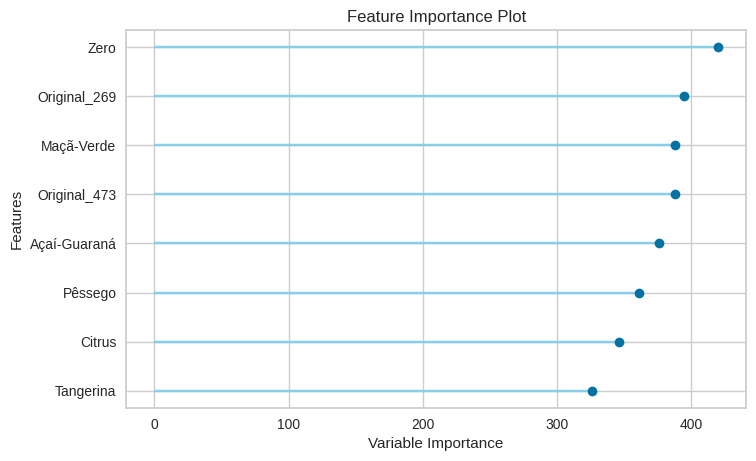

In [ ]:
plot_model(lgbm, plot="feature")

In [ ]:
best = automl(optimize="F1")
best

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=100,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.7,
               n_estimators=50, n_jobs=-1, num_leaves=10, objective=None,
               random_state=42, reg_alpha=0.1, reg_lambda=0.6, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

### TPOT

In [ ]:
tp = TPOTClassifier(random_state=0, verbosity=2, scoring="f1_micro")
tp.fit(X_rus, y_rus)
tp.export("pipeline7")


Generation 1 - Current best internal CV score: 0.8419145965325597
Generation 2 - Current best internal CV score: 0.8419145965325597
Generation 3 - Current best internal CV score: 0.8419145965325597
Generation 4 - Current best internal CV score: 0.8419145965325597
Generation 5 - Current best internal CV score: 0.8419145965325597
Generation 6 - Current best internal CV score: 0.8419145965325597
Generation 7 - Current best internal CV score: 0.8419145965325597
Generation 8 - Current best internal CV score: 0.8420500978875733
Generation 9 - Current best internal CV score: 0.8420500978875733
Generation 10 - Current best internal CV score: 0.8420500978875733
Generation 11 - Current best internal CV score: 0.8420500978875733
Generation 12 - Current best internal CV score: 0.8420500978875733
Generation 13 - Current best internal CV score: 0.8420500978875733

TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: RandomFo

In [ ]:
from sklearn.preprocessing import FunctionTransformer
from copy import copy

# Average CV score on the training set was: 0.8286996328153202
pipeline3 = make_pipeline(
    make_union(
        FunctionTransformer(copy),
        FunctionTransformer(copy)
    ),
    ExtraTreesClassifier(bootstrap=False, criterion="gini", max_features=0.25, 
                         min_samples_leaf=3, min_samples_split=5, n_estimators=100)
)
# Fix random state for all the steps in exported pipeline
set_param_recursive(pipeline3.steps, 'random_state', 0)

pipeline3.fit(X_smt, y_smt)
results = pipeline3.predict(X_test)
print(classification_report(y_test, results))

In [ ]:
X_rus.shape, X_test.shape

In [ ]:
# Average CV score on the training set was: 0.8441054091539527
pipeline4 = XGBClassifier(learning_rate=0.01, max_depth=7, min_child_weight=7,
                          n_estimators=100, nthread=1, subsample=0.3, random_state=0)
pipeline4.fit(X_rus, y_rus)
results = pipeline4.predict(np.array(X_test))
print(classification_report(y_test, results))

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import make_pipeline
from tpot.export_utils import set_param_recursive

# Average CV score on the training set was: 0.8445214979195562
exported_pipeline = make_pipeline(
    VarianceThreshold(threshold=0.001),
    GradientBoostingClassifier(learning_rate=0.001, max_depth=8, max_features=0.8, min_samples_leaf=1, min_samples_split=20, n_estimators=100, subsample=0.15000000000000002)
)
# Fix random state for all the steps in exported pipeline
set_param_recursive(exported_pipeline.steps, 'random_state', 0)

exported_pipeline.fit(X_rus, y_rus)
results = exported_pipeline.predict(X_test)
print(classification_report(y_test, results))

In [ ]:
from sklearn.preprocessing import MaxAbsScaler
from sklearn.tree import DecisionTreeClassifier
from tpot.export_utils import set_param_recursive

# Average CV score on the training set was: 0.7754606592586416
exported_pipeline = make_pipeline(
    MaxAbsScaler(),
    DecisionTreeClassifier(criterion="gini", max_depth=8, min_samples_leaf=17, min_samples_split=17)
)
# Fix random state for all the steps in exported pipeline
set_param_recursive(exported_pipeline.steps, 'random_state', 0)

exported_pipeline.fit(X_train, y_train)
results = exported_pipeline.predict(X_test)
print(classification_report(y_test, results, digits=4))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# Average CV score on the training set was: 0.8420 | 0.7845
pipeline7 = RandomForestClassifier(bootstrap=False, max_features=0.2, 
                                   min_samples_leaf=19, min_samples_split=5,
                                   n_estimators=100, random_state=0)
pipeline7.fit(X_rus, y_rus)
results = pipeline7.predict(X_test)
print(classification_report(y_test, results, digits=4))

              precision    recall  f1-score   support

      NORMAL     0.9996    0.6788    0.8085      3334
 REABASTECER     0.6049    0.9994    0.7537      1641

    accuracy                         0.7845      4975
   macro avg     0.8023    0.8391    0.7811      4975
weighted avg     0.8694    0.7845    0.7904      4975



### TPOT Droped

In [ ]:
tp = TPOTClassifier(random_state=0, verbosity=2, scoring="f1_micro")
tp.fit(X_rus_droped, y_rus_droped)
tp.export("pipeline1_droped")


Generation 1 - Current best internal CV score: 0.8408044068597066
Generation 2 - Current best internal CV score: 0.8408044068597066
Generation 3 - Current best internal CV score: 0.8408044068597066
Generation 4 - Current best internal CV score: 0.8408044068597066
Generation 5 - Current best internal CV score: 0.8408044068597066
Generation 6 - Current best internal CV score: 0.840940276424924
Generation 7 - Current best internal CV score: 0.840940276424924
Generation 8 - Current best internal CV score: 0.840940276424924
Generation 9 - Current best internal CV score: 0.840940276424924
Generation 10 - Current best internal CV score: 0.840940276424924
Generation 11 - Current best internal CV score: 0.840940276424924
Generation 12 - Current best internal CV score: 0.840940276424924
Generation 13 - Current best internal CV score: 0.840940276424924
Generation 14 - Current best internal CV score: 0.840940276424924
Generation 15 - Current best internal CV score: 0.840940276424924
Generation 16

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# Average CV score on the training set was: 0.840940276424924
pipeline1_droped = RandomForestClassifier(bootstrap=True, criterion="gini", 
                                          max_features=0.25, min_samples_leaf=11, 
                                          min_samples_split=14, n_estimators=100, 
                                          random_state=0)

pipeline1_droped.fit(X_rus_droped, y_rus_droped)
results = pipeline1_droped.predict(X_test_droped)
print(f1_score(y_test_droped, results, average="micro"))
print(classification_report(y_test_droped, results, digits=4))

0.7872811430871403
              precision    recall  f1-score   support

      NORMAL     1.0000    0.6833    0.8119      3338
 REABASTECER     0.6068    1.0000    0.7553      1631

    accuracy                         0.7873      4969
   macro avg     0.8034    0.8417    0.7836      4969
weighted avg     0.8709    0.7873    0.7933      4969



### GP minimize

In [ ]:
!pip install scikit-optimize

In [ ]:
from skopt import gp_minimize

def tunar_modelo(params):
  learning_rate = params[0]
  max_depth = params[1]
  min_child_weight = params[2]
  n_estimators = params[3]
  subsample = params[4]

  print(params,'\n')
  mdl = XGBClassifier(  
      learning_rate = learning_rate, n_estimators = n_estimators,
      max_depth = max_depth, min_child_weight = min_child_weight,
      subsample = subsample, random_state = 0)
  
  mdl.fit(X_res, y_res)
  p = mdl.predict(np.array(X_test))
  return -f1_score(y_test, p, average="micro")

space = [(1e-2, 1e-1), # learning_rate
         (1, 1000), # n_estimators
         (1, 100), # max_depth
         (1, 100), # min_child_weight, 
         (0, 1)] # subsample

resultado_gp = gp_minimize(tunar_modelo, space, random_state=0, 
                           n_calls=1000, n_random_starts=100, verbose=1)

## Validando

In [ ]:
df_toScore[colsInt] = df_toScore[colsInt].astype(int)

df_toScore[["LAT", "LONG"]] = df_toScore[["LAT", "LONG"]].astype(float)

df_toScore["ano"] = df_toScore["Tempo"].str[:4].astype(int)
df_toScore["mes"] = df_toScore["Tempo"].str[5:7].str.replace("-", "").astype(int)
df_toScore["dia"] = df_toScore["Tempo"].str[7:].str.replace("-", "").astype(int)

df_toScore["quantidade"] = df_toScore[bebidas].sum(axis=1)
df_toScore["media"] = df_toScore[bebidas].mean(axis=1).astype(int)
df_toScore["min"] = df_toScore[bebidas].min(axis=1)
df_toScore["max"] = df_toScore[bebidas].max(axis=1)

df_toScore["logMovQunt"] = np.log(df_toScore["Movimentação"] / df_toScore["quantidade"])

df_toScore = df_toScore.drop(["Estação", "Tempo", "LAT", "LONG"], axis=1)
df_toScore = df_toScore[bebidas + ["min", "quantidade"]]
df_toScore

In [ ]:
scored = pipeline3.predict(df_toScore2)
scored = pd.DataFrame(scored, columns=["TARGET"])
scored.to_csv("results", index=False)

In [ ]:
scored3 = fs.predict(df_toScore)
scored3_full = pd.concat([df_toScore, pd.Series(scored3, name="TARGET")], axis=1)
scored3_full

,Original_473,Original_269,Zero,Maçã-Verde,Tangerina,Citrus,Açaí-Guaraná,Pêssego,min,quantidade,TARGET
0,22,65,22,14,3,26,43,18,3,213,REABASTECER
1,11,56,16,14,43,20,37,15,11,212,REABASTECER
2,86,51,8,11,41,20,35,12,8,264,REABASTECER
3,76,47,65,11,37,14,32,10,10,292,NORMAL
4,68,42,60,6,35,13,26,5,5,255,NORMAL
...,...,...,...,...,...,...,...,...,...,...,...
979,34,65,28,17,33,27,6,2,2,212,REABASTECER
980,21,60,18,15,27,22,43,43,15,249,NORMAL
981,9,56,13,14,21,17,37,37,9,204,REABASTECER
982,86,49,7,14,17,12,33,33,7,251,REABASTECER


In [ ]:
Submission3 = df_toScore[["Original_473",	"Original_269",	"Zero",	"min"]]
Submission3_predict = pipeline1_droped.predict(Submission3)
pd.DataFrame(Submission3_predict, columns=["TARGET"]).to_csv("results", index=False)

In [ ]:
X_df = df[["Original_473",	"Original_269",	"Zero",	"min"]]
y_df = df["TARGET"]
pred_df = pipeline1_droped.predict(X_df)
print(f1_score(y_df, pred_df, average="micro"))

mdl_df2 = RandomForestClassifier(bootstrap=True, criterion="gini", 
                                          max_features=0.25, min_samples_leaf=11, 
                                          min_samples_split=14, n_estimators=100, 
                                          random_state=0)
mdl_df2.fit(X_train[["Original_473",	"Original_269",	"Zero",	"min"]], y_train)
pred_df2 = mdl_df2.predict(X_df)
print(f1_score(y_df, pred_df2, average="micro"))

0.785912435170667
0.8125075382945363


### Analisando o Target

In [ ]:
scored3_full.groupby(by="TARGET").min()

,Original_473,Original_269,Zero,Maçã-Verde,Tangerina,Citrus,Açaí-Guaraná,Pêssego,min,quantidade
TARGET,,,,,,,,,,
NORMAL,4,6,3,6,2,6,2,5,2,150
REABASTECER,0,0,0,1,1,1,1,1,0,106


* Não há nenhuma bebida abaixo de 2 em situação normal

In [ ]:
Submission3_full = pd.concat([Submission3, pd.Series(Submission3_predict, name="TARGET")],axis=1)
Submission3_full.groupby("TARGET").min()

,Original_473,Original_269,Zero,min
TARGET,,,,
NORMAL,13,10,10,7
REABASTECER,0,0,0,0


In [ ]:
scored3_full.groupby("TARGET").max()

,Original_473,Original_269,Zero,Maçã-Verde,Tangerina,Citrus,Açaí-Guaraná,Pêssego,min,quantidade
TARGET,,,,,,,,,,
NORMAL,86,65,65,43,43,43,43,43,43,431
REABASTECER,86,65,65,43,43,43,43,43,12,333


* Não há nenhuma bebida acima de 12 em situação reabastecer

In [ ]:
scored3_full.groupby("TARGET").median()

,Original_473,Original_269,Zero,Maçã-Verde,Tangerina,Citrus,Açaí-Guaraná,Pêssego,min,quantidade
TARGET,,,,,,,,,,
NORMAL,51.0,38.0,39.0,27.0,26.0,26.0,26.5,27.0,11.0,259.0
REABASTECER,43.0,35.0,33.0,24.0,21.0,23.0,22.0,20.0,5.0,224.0


### Analizando a predição

array(['NORMAL', 'REABASTECER', 'REABASTECER', ..., 'NORMAL',
       'REABASTECER', 'NORMAL'], dtype=object)

In [ ]:
results1 = pd.read_csv("/content/results1.csv")
results2 = pd.read_csv("/content/results2.csv")

In [ ]:
results2.TARGET[30] != results[30]

True

In [ ]:
count12, count23, count13 = [0,0,0]
for row in range(0,984):
  if results[row] != results2.TARGET[row]:
    count23+=1
  if results1.TARGET[row] != results[row]:
    count13+=1
  if results1.TARGET[row] != results2.TARGET[row]:
    count12+=1
print(count12, count23, count13)

65 485 488
